In [1]:
import sys
sys.path.insert(0, "../src")
import example_helper as eh
import analysis_helper as ah
import msgpack
import zlib
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns; sns.set()

# Get Data

In [2]:
# define the location of the input file
filename_augmento_topics = "../data/example_data/augmento_topics.msgpack.zlib"
filename_augmento_data = "../data/example_data/augmento_data.msgpack.zlib"
filename_bitmex_data = "../data/example_data/bitmex_data.msgpack.zlib"

# load the example data
all_data = eh.load_example_data(filename_augmento_topics,
                             filename_augmento_data,
                             filename_bitmex_data)
aug_topics, aug_topics_inv, t_aug_data, aug_data, t_price_data, price_data = all_data

In [3]:
all_topics = aug_data.T.astype(float)
#all_topics.shape

In [4]:
# calculate PNL for a given strategy
# if sentiment positive go long, else go short
# fees are assumed to be 0.75% (taker fee from BITMEX)

def strategy(price_data, signal_a, signal_b, window_1 = 24 * 7, window_2 = 24*7,buy_sell_fee = 0.0, pnl_0 = 1.0):    
    sent_score = ah.nb_calc_sentiment_score_a(signal_a,signal_b,window_1,window_2)
    pnl = ah.nb_backtest_a(price_data, sent_score, 1.0, buy_sell_fee)
    return pnl

# PNL of various moving window size for a given combination of topics
def window_combination(price_data,top_a,top_b,end_day_x,end_day_y,start_day_x=0,start_day_y=0,buy_sell_fee=0.0075):
    total_comb = np.zeros(shape=(end_day_x,end_day_y))
    print("Calculating...")
    for i in range(start_day_x,end_day_x):
        for j in range(start_day_y,end_day_y):
            total_comb[i][j] = strategy(price_data,top_a,top_b,window_1=24*(i+1),window_2=24*(j+1),buy_sell_fee = buy_sell_fee)[-1]
    print("Done.")
    return total_comb[start_day_x:end_day_x,start_day_y:end_day_y]
    

In [5]:
# for each combination of signals, generate PNL for the last period in data
total = np.zeros(shape=(93,93))
print("calculating... might take a minute or two...")
for i in range(0,len(all_topics)):
    for j in range(0,len(all_topics)):
        total[i][j] = strategy(price_data, all_topics[i], all_topics[j], window_1=24*7,window_2=24*7)[-1]
    #print("Row " + str(i+1) + " out of 93...")
print("done")

calculating... might take a minute or two...
done


In [6]:
# get all PNL in a dataframe
data = pd.DataFrame(total).rename(columns=aug_topics,index=aug_topics)
# given all combinations of signals, show the combinations that yield the highest PNL
c = data.abs()
s = c.unstack()
so_st = s.sort_values(kind="quicksort")
# specify n, a number of top combinations to be shown
t = so_st.tail(n=30).index

In [7]:
# labels for graphs and tables
columns_t = dict((y, x) for x, y in t).keys()
rows_t = dict((x, y) for x, y in t).keys()

In [8]:
# pick from the dataframes only the pairs of strategies that are within the top list
top = data[rows_t].loc[columns_t]

# Heat Map for top 30 pairs

In [9]:
# a sorted dataframe to get highest PNLs in the first rows
idx = pd.unique([i[1] for i in np.flip(t.values)])
col = pd.unique([i[0] for i in np.flip(t.values)])
sorted_df = data[col].loc[idx]

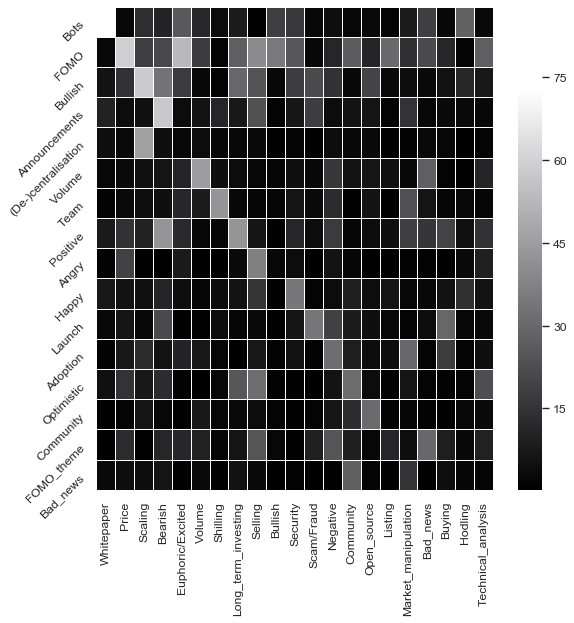

In [10]:
# plot a heat map with top 30 PNLs
# light colors indicate high, while dark colors low values
m = np.array(sorted_df)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.0, dark=1.2, as_cmap=True)
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(m, linewidth=0.01, cmap=cmap)
ax.set_xticklabels(col, rotation=90)
ax.set_yticklabels(idx, rotation = 45)
plt.show()

# Testing for different windows sizes

## 1. same window size for rolling std and average

In [11]:
# recompute the NLP matrix for the above found combinations for window sizes from 1 to number of days specified
number_of_days = 30
top_n = 20
t_10 = so_st.tail(n=top_n).index
empty = np.zeros([top_n, number_of_days])
for j in range(len(t_10)):
    for days in range(1,(number_of_days+1)):    
        a = strategy(price_data,all_topics[aug_topics_inv[t_10[j][1]]],all_topics[aug_topics_inv[t_10[j][0]]],window_1=24*days,window_2=24*days)[-1]
        empty[j][days-1] = a

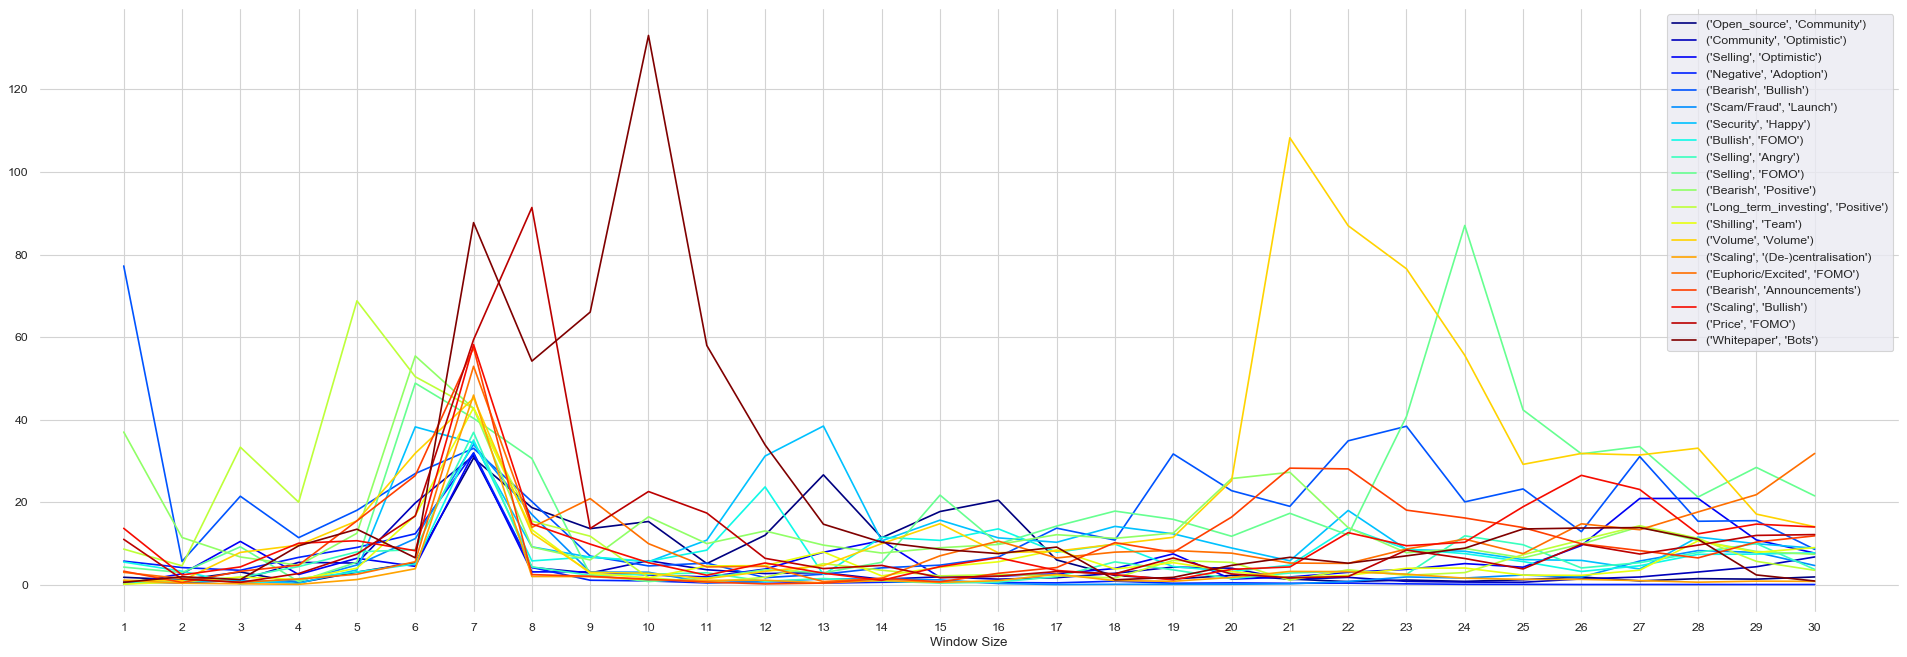

In [12]:
# plot the combinations for different window sizes
figure(num=None, figsize=(30, 10), dpi=80)
days_a = np.arange(number_of_days)
labels = t_10.values
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0,20))
ax = plt.gca()
ax.set_facecolor("white")
for i , label, color in zip(empty,labels,colors):
    plt.plot(days_a,i,label=label,color=color)
    plt.xticks(np.arange(number_of_days), np.arange(1,number_of_days+1))
    plt.legend()
    plt.xlabel("Window Size")
    plt.grid(color="lightgrey")


# Different rolling mean and std window sizes

From a chosen pair of topics, compute NLP for various rolling average and rolling std

#### example for 'Bots' and 'Whitepaper'

In [13]:
#specify tags
ix = 0 # specify startpoint number of rolling mean
iy = 0 # specify startpoint of rolling std
end_x = 30 # specify endpoint number of rolling mean
end_y = 40 # specify endpoint of rolling std
topic_a = 'Bots'
topic_b = 'Whitepaper'
top_b = all_topics[aug_topics_inv[topic_b]]
top_a = all_topics[aug_topics_inv[topic_a]]
total_s = window_combination(price_data,top_a,top_b,end_x,end_y,start_day_x=ix,start_day_y=iy)

Calculating...
Done.


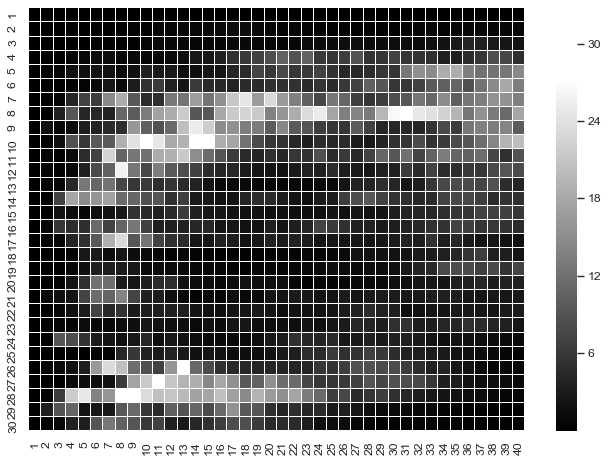

In [14]:
# plot
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.0, dark=1.2, as_cmap=True)
figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(total_s, linewidth=0.01, cmap=cmap,yticklabels=np.arange(ix+1,end_x+1),xticklabels=np.arange(iy+1,end_y+1))
plt.show()

#### example for 'Bullish' and 'Bearish'

In [15]:
#specify tags
ix = 16
iy = 10
end_x = 24
end_y = 24
topic_a = 'Bullish'
topic_b = 'Bearish'
top_b = all_topics[aug_topics_inv[topic_b]]
top_a = all_topics[aug_topics_inv[topic_a]]
total_s = window_combination(price_data,top_a,top_b,end_x,end_y,start_day_x=ix,start_day_y=iy)

Calculating...
Done.


In [16]:
# plot
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.0, dark=1.2, as_cmap=True)
figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(total_s, linewidth=0.01, cmap=cmap,yticklabels=np.arange(ix+1,end+1),xticklabels=np.arange(iy+1,end+1))

plt.show()

NameError: name 'end' is not defined

<Figure size 800x560 with 0 Axes>